## Imports

In [2]:
%load_ext autoreload
%autoreload 2

# Standard imports
import glob

# 3rd party imports
import cv2
import matplotlib.pyplot as plt
import numpy as np 
from pprint import pprint
import SimpleITK as sitk
sitk.ProcessObject_SetGlobalWarningDisplay(False)
from scipy import ndimage

## Functions

In [3]:
def load_channel(filepath: str, idx: int, debug=False) -> np.ndarray:
    """
    Load the image channels from the given filepath.
    
    Args:
        filepath: str, path to the image
        idx: int, index of the image to load
        
    Returns:
        channels: np.ndarray, image channels
    """
    filepaths = sorted(glob.glob(filepath))
    
    
    # Load the image
    curr_img = read_tif(filepaths[idx])
    
    if debug:
        print(f"Found {int(len(filepaths))} slices")
        pprint(filepaths)
        print("\nImage:", filepaths[idx])

        # Check image stats
        print(f"\nChannel shape: {curr_img.shape}")
        print(f"Channel dtype: {curr_img.dtype}")
        print(f"Channel min: {curr_img.min()}")
        print(f"Channel max: {curr_img.max()}")
        print(f"Channel mean: {curr_img.mean()}")
        
    return curr_img, filepaths[idx]


### Functions for IO operations
def load_channels(filepath: str, idx: int) -> np.ndarray:
    """
    Load the image channels from the given filepath.
    
    Args:
        filepath: str, path to the image
        idx: int, index of the image to load
        
    Returns:
        channels: np.ndarray, image channels
    """
    filepaths = sorted(glob.glob(filepath))
    print(f"Found {int(len(filepaths)/2)} slices")
    pprint(filepaths)
    
    # Load the image
    file_idx = idx * 2  # Multiply by 2 because we have 2 channels and they're stored in pairs
    curr_img = (read_tif(filepaths[file_idx]), read_tif(filepaths[file_idx + 1]))
    print("\nCh1:", filepaths[file_idx])
    print("Ch2:", filepaths[file_idx + 1])
    curr_ch1 = curr_img[0]
    curr_ch2 = curr_img[1]

    # Check image stats
    print(f"\nChannel shape: {curr_ch1.shape}")
    print(f"Channel dtype: {curr_ch1.dtype}")
    print(f"Channel 1 min: {curr_ch1.min()}")
    print(f"Channel 1 max: {curr_ch1.max()}")
    print(f"Channel 1 mean: {curr_ch1.mean()}")
    
    return curr_ch1, curr_ch2


def read_tif(filepath):
    """
    Read tiff files using SimpleITK
    
    Args:
        filepath: str, path to tiff file
        
    Returns:
        image: np.ndarray, tiff image
    """
    image = sitk.ReadImage(filepath)
    image = sitk.GetArrayFromImage(image)
    return image


def auto_contrast(data: np.ndarray, alpha: float = None, beta: float = None) -> np.ndarray:
    """
    Preprocess tiff files to automatically adjust brightness and contrast.
    https://stackoverflow.com/questions/56905592/automatic-contrast-and-brightness-adjustment-of-a-color-photo-of-a-sheet-of-pape
    """
    if not alpha:
        alpha = np.iinfo(data.dtype).max / (np.max(data) - np.min(data))
    if not beta:
        beta = -np.min(data) * alpha
    img = cv2.convertScaleAbs(data.copy(), alpha=alpha, beta=beta)
    return img


def gamma_correction(image: np.ndarray, gamma: float=2.0, min_value=None, max_value=None) -> np.ndarray:
    """
    Apply gamma correction to the image.
    
    Args:
        image: np.ndarray, input image
        gamma: float, gamma value
        
    Returns:
        image_enhanced: np.ndarray, gamma corrected image
    """
    if min_value is not None:
        image = image.copy()
        image[image < min_value] = 0
    if max_value is None:
        max_value = image.max()
    else:
        image = image.copy()
        image[image > max_value] = max_value
    # Normalize the image to the range [0, 1]
    image_normalized = image / max_value
    # Apply the exponential transformation
    image_enhanced = np.power(image_normalized, gamma)
    # Rescale the image back to the original intensity range
    image_enhanced = image_enhanced * max_value
    return image_enhanced


def save_figure(image, filename, contours=None):
    """
    Save figure to disk.
    
    Args:
        image: np.ndarray, input image
        filename: str, path to save the image
        contours: np.ndarray, contours to overlay on the image
    """
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap='gray')
    if contours is not None:
        plt.contour(contours, colors='red', linewidths=0.15, alpha=0.35)
    plt.axis('off')
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    print(f"Saved figure to {filename}")
    
    
def show(image: np.ndarray, contour: np.ndarray = None,
         image2: np.ndarray = None, contour2: np.ndarray = None, contour_alpha: float = 0.75,
         title: str = "", title2: str = "", 
         xlim: tuple[int, int] = None, ylim: tuple[int, int] = None,
         xlim2: tuple[int, int] = None, ylim2: tuple[int, int] = None,
         axis: bool = True,
         figsize: tuple[int, int] = (10, 10)):
    """
    Display the image.
    
    Args:
        image: np.ndarray, input image
        title: str, title of the image
    """
    f = plt.figure(figsize=figsize)
    # If there are two images, display them side by side
    if image2 is not None:
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        if contour is not None:
            plt.contour(contour, colors='red', linewidths=0.5, alpha=contour_alpha)
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        plt.axis(axis)
        plt.subplot(1, 2, 2)
        plt.imshow(image2, cmap='gray')
        plt.title(title2)
        if contour2 is not None:
            plt.contour(contour2, colors='red', linewidths=0.5, alpha=contour_alpha)
        if xlim2 is not None:
            plt.xlim(xlim2)
        if ylim2 is not None:
            plt.ylim(ylim2)
        plt.axis(axis)
    # If there is only one image, display it
    else:
        plt.imshow(image, cmap='gray')
        plt.title(title)
        if contour is not None:
            plt.contour(contour, colors='red', linewidths=0.5, alpha=contour_alpha)
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        plt.axis(axis)
    plt.show()
    f.clear()
    plt.close(f)

In [4]:
### Functions for vessel detection
import itk
import numpy as np
from skimage.morphology import remove_small_objects, binary_closing, disk, remove_small_holes

# Parameters for vessel detection
ALPHA = 0.5  # Default 0.5
BETA = 0.5  # Default 1
GAMMA = 5.0  # Default 5

def detect_vessels(input_image: np.ndarray, min_sigma: float=1.0, max_sigma: float=10.0, num_steps: int=10):
    """
    Use the Hessian-based vesselness filter to detect vessels in the image.
    
    Args:
        input_image: np.ndarray, input image
        min_sigma: float, minimum sigma value
        max_sigma: float, maximum sigma value
        num_steps: int, number of steps
        
    Returns:
        segmented_vessels_array: np.ndarray, segmented vessels
    """
    # Run ITK
    input_image = itk.image_from_array(input_image)
    #input_image = itk.imread(input_image, itk.F)

    ImageType = type(input_image)
    Dimension = input_image.GetImageDimension()
    HessianPixelType = itk.SymmetricSecondRankTensor[itk.D, Dimension]
    HessianImageType = itk.Image[HessianPixelType, Dimension]

    objectness_filter = itk.HessianToObjectnessMeasureImageFilter[
        HessianImageType, ImageType
    ].New()
    objectness_filter.SetBrightObject(False)  # Set to True if the structures are bright on a dark background
    objectness_filter.SetScaleObjectnessMeasure(False)  # Set to True to scale the objectness measure by the scale
    objectness_filter.SetAlpha(ALPHA)  # Sensitivity to blob-like structures
                                     # Set/Get Alpha, the weight corresponding to R_A 
                                     # (the ratio of the smallest eigenvalue that has to be large to the larger ones). 
                                     # Smaller values lead to increased sensitivity to the object dimensionality.
    objectness_filter.SetBeta(BETA)   # Sensitivity to plate-like structures - 1.0 default
                                     # Set/Get Beta, the weight corresponding to R_B 
                                     # (the ratio of the largest eigenvalue that has to be small to the larger ones). 
                                     # Smaller values lead to increased sensitivity to the object dimensionality.
    objectness_filter.SetGamma(GAMMA)  # Sensitivity to noise - 5.0 default
                                     # Set/Get Gamma, the weight corresponding to S 
                                     # (the Frobenius norm of the Hessian matrix, or second-order structureness)

    multi_scale_filter = itk.MultiScaleHessianBasedMeasureImageFilter[
        ImageType, HessianImageType, ImageType
    ].New()
    multi_scale_filter.SetInput(input_image)
    multi_scale_filter.SetHessianToMeasureFilter(objectness_filter)
    multi_scale_filter.SetSigmaStepMethodToLogarithmic()
    multi_scale_filter.SetSigmaMinimum(min_sigma)
    multi_scale_filter.SetSigmaMaximum(max_sigma)
    multi_scale_filter.SetNumberOfSigmaSteps(num_steps)

    OutputPixelType = itk.UC
    OutputImageType = itk.Image[OutputPixelType, Dimension]

    rescale_filter = itk.RescaleIntensityImageFilter[ImageType, OutputImageType].New()
    rescale_filter.SetInput(multi_scale_filter)
    rescale_filter.Update()

    # Get numpy array
    segmented_vessels = rescale_filter.GetOutput()
    segmented_vessels_array = itk.array_view_from_image(segmented_vessels)
    segmented_vessels_array = np.asarray(segmented_vessels_array, dtype=np.float32)
    return segmented_vessels_array


def process_vessels(vessel_image: np.ndarray, thresh: int, min_size: int=10, area_threshold: float=2000, smoothing: int=3):
    """
    Process the thresholded vessels.
    
    Args:
        vessel_image: np.ndarray, input image
        thresh: int, threshold value
        min_size: int, minimum size
        area_threshold: float, area threshold
        smoothing: int, smoothing factor
        
    Returns:
        thresholded_vessels: np.ndarray, thresholded vessels
    """
    # Process the thresholded vessels
    thresholded_vessels = vessel_image > thresh
    thresholded_vessels = np.invert(thresholded_vessels)

    # Get rid of small objects
    thresholded_vessels = remove_small_objects(thresholded_vessels, min_size=min_size)
    thresholded_vessels = remove_small_holes(thresholded_vessels, area_threshold=area_threshold)

    # Smoothen edges
    thresholded_vessels = binary_closing(thresholded_vessels, footprint=disk(smoothing))
    
    return thresholded_vessels


def get_brain_mask(brain_image, area_threshold=300000, min_size=10000):
    """
    Get the mask of the brain from the image (run before contrast enhancement).
    
    Args:
        brain_image: np.ndarray, input image
        thresh: int, threshold value
        area_threshold: int, area threshold
        
    Returns:
        mask: np.ndarray, mask of the brain
    """
    _, mask = cv2.threshold(brain_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
    mask = remove_small_holes(mask.astype(bool), area_threshold=area_threshold)
    mask = remove_small_objects(mask, min_size=min_size)
    return mask


In [5]:
### Functions for evaluation
import csv
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from scipy.spatial.distance import hamming

def dice_coefficient(binary_image1, binary_image2, epsilon=1e-10):
    """
    Compute the Dice coefficient between two binary images.
    
    Parameters:
    - binary_image1: First binary image (numpy array).
    - binary_image2: Second binary image (numpy array).
    
    Returns:
    - dice: Dice coefficient.
    """
    intersection = np.sum(binary_image1 * binary_image2)
    size1 = np.sum(binary_image1)
    size2 = np.sum(binary_image2)
    
    dice = (2. * intersection + epsilon) / (size1 + size2 + epsilon)
    return dice


def iou(binary_image1, binary_image2, epsilon=1e-10):
    """
    Compute the Intersection over Union (IoU) between two binary images.
    
    Parameters:
    - binary_image1: First binary image (numpy array).
    - binary_image2: Second binary image (numpy array).
    
    Returns:
    - iou: IoU.
    """
    intersection = np.sum(binary_image1 * binary_image2)
    union = np.sum(binary_image1 + binary_image2)
    
    if union == 0:
        iou = 1.0
    
    iou = (intersection + epsilon) / (union + epsilon)
    return iou


def precision(binary_image1, binary_image2, epsilon=1e-10):
    """
    Compute the precision between two binary images.
    
    Parameters:
    - binary_image1: First binary image (numpy array).
    - binary_image2: Second binary image (numpy array).
    
    Returns:
    - precision: Precision.
    """
    true_positives = np.sum(binary_image1 * binary_image2)
    false_positives = np.sum(binary_image1 * (1 - binary_image2))
    
    precision = (true_positives) / (true_positives + false_positives + epsilon)
    return precision


def recall(binary_image1, binary_image2, epsilon=1e-10):
    """
    Compute the recall between two binary images.
    
    Parameters:
    - binary_image1: First binary image (numpy array).
    - binary_image2: Second binary image (numpy array).
    
    Returns:
    - recall: Recall.
    """
    true_positives = np.sum(binary_image1 * binary_image2)
    false_negatives = np.sum((1 - binary_image1) * binary_image2)
    
    recall = true_positives / (true_positives + false_negatives + epsilon)
    return recall


def rand_index(binary_image1, binary_image2):
    """
    Compute the Rand index between two binary images.
    
    Parameters:
    - binary_image1: First binary image (numpy array).
    - binary_image2: Second binary image (numpy array).
    
    Returns:
    - rand_index: Rand index.
    """
    true_positives = np.sum(binary_image1 * binary_image2)
    false_positives = np.sum(binary_image1 * (1 - binary_image2))
    false_negatives = np.sum((1 - binary_image1) * binary_image2)
    true_negatives = np.sum((1 - binary_image1) * (1 - binary_image2))
    
    rand_index = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives)
    return rand_index

In [6]:
import time 
import scipy.ndimage
from scipy.ndimage import median_filter

def n4_bias_correction(img, bg_mask, shrink_factor: float=15, show: bool=False) -> np.ndarray:
    """
    N4 bias correction for the input image.
    
    Parameters:
    - img: The input image to correct.
    - alpha: The alpha value for contrast adjustment.
    - shrink_factor: The shrink factor for downsampling the image for bias correction.
    - show: Whether to show the intermediate results.
    
    Returns:
    - corrected_image_full_resolution: The bias corrected image.
    """
    # Get contrast image for mask
    #contrast_img = auto_contrast(img, alpha=alpha)
    
    # Create the brain tissue mask
    #mask_img = sitk.GetImageFromArray(contrast_img)
    #mask_img = sitk.RescaleIntensity(mask_img, 0, 255)
    #mask_img = sitk.LiThreshold(mask_img, 0, 1)
    bg_mask = bg_mask.astype(np.uint8)
    mask_img = sitk.GetImageFromArray(bg_mask)
    mask_img = sitk.LiThreshold(mask_img, 0, 1)

    # Use the raw image and convert it to float32
    raw_img = sitk.GetImageFromArray(img.copy())
    raw_img = sitk.Cast(raw_img, sitk.sitkFloat32)

    # Downsample it for bias correction
    inputImage = raw_img
    if shrink_factor > 1:
        inputImage = sitk.Shrink( raw_img, [ shrink_factor ] * raw_img.GetDimension() ) #2
        maskImage = sitk.Shrink( mask_img, [ shrink_factor ] * inputImage.GetDimension() ) #3

    # Run bias correction
    start_time = time.time()
    bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected = bias_corrector.Execute(inputImage, maskImage)
    
    # Apply bias correction to full resolution image
    log_bias_field = bias_corrector.GetLogBiasFieldAsImage(raw_img)
    corrected_image_full_resolution = raw_img / sitk.Exp(log_bias_field)
    end_time = time.time()
    corrected_image_full_resolution = sitk.GetArrayFromImage(corrected_image_full_resolution)
    
    # Show the process if True
    if show:
        print(f"Time taken for bias correction: {end_time - start_time:.2f} seconds")
        
        # Show the brain tissue mask
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(sitk.GetArrayFromImage(mask_img), cmap='gray')
        plt.title(f"Full resolution brain mask")
        plt.subplot(1, 2, 2)
        plt.imshow(sitk.GetArrayFromImage(maskImage), cmap='gray')
        plt.title(f"Downsampled brain mask (shrink factor={shrink_factor})")
        plt.show()
        
        # Show the log bias field
        plt.figure(figsize=(10, 5))
        plt.imshow(sitk.GetArrayFromImage(log_bias_field))
        plt.colorbar()
        plt.title(f"Log bias field")
        plt.show()

        # Show the corrected bias field image
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original raw image")
        plt.subplot(1, 2, 2)
        plt.imshow(corrected_image_full_resolution, cmap='gray')
        plt.title(f"Corrected bias raw image")
        plt.show()

        # Increase the contrast of the corrected image and show side-by-side
        preview_alpha = 0.25
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        contrast_comparison = auto_contrast(img, alpha=preview_alpha)
        plt.imshow(contrast_comparison, cmap='gray')
        plt.title(f"Original contrast image (alpha={preview_alpha})")
        plt.subplot(1, 2, 2)
        corrected_bias_contrast = auto_contrast(corrected_image_full_resolution, alpha=preview_alpha)
        plt.imshow(corrected_bias_contrast, cmap='gray')
        plt.title(f"Corrected bias contrast image (alpha={preview_alpha})")
        plt.show()
        
    return corrected_image_full_resolution


def preprocess_image(img, alpha: float=1, shrink_factor: float=15, 
                     median_filter_size: int=5, gaussian_sigma: float=0.2, 
                     show: bool=False) -> np.ndarray:
    """
    Preprocess the image using N4 bias correction and filtering.
    
    Parameters:
    - img: The input image to preprocess.
    - alpha: The alpha value for contrast adjustment.
    - shrink_factor: The shrink factor for downsampling the image for bias correction.
    - median_filter_size: The size of the median filter to apply.
    - gaussian_sigma: The sigma value for the Gaussian filter to apply.
    - show: Whether to show the intermediate results.
    
    Returns:
    - corrected_img: The preprocessed image.
    """
    corrected_bias_img = n4_bias_correction(img, alpha=alpha, shrink_factor=shrink_factor, show=show)

    # Run median filter
    median_filtered_img = median_filter(corrected_bias_img.copy(), size=median_filter_size)

    # Run gaussian filter
    gaussian_filtered_img = scipy.ndimage.gaussian_filter(median_filtered_img.copy(), sigma=gaussian_sigma)

    #if show:
    #    get_stats(img, title="Original image stats:")
    #    get_stats(corrected_bias_img, title="N4 bias corrected image stats:")
    #    get_stats(median_filtered_img, title="Median filtered image stats:")
    #    get_stats(gaussian_filtered_img, title="Gaussian filtered image stats:")
        
    corrected_img = gaussian_filtered_img        
    return corrected_img


## Load data

In [82]:
import os
from skimage.measure import regionprops, label
from skimage.morphology import skeletonize, medial_axis
from pprint import pprint
import csv

# IO parameters
filepath = "/media/data/u01/Fig2025/Supplemental Fig3 DE/M1/*.tif"
output_csv_path = "/media/data/u01/Fig2025/quant-fig2025/Supple-3-DE/M1/"
output_image_path = "/media/data/u01/Fig2025/quant-fig2025/Supple-3-DE/M1/segmentation/"
IDX = 18  # 13, 14, 16 M1
N = 251
FILL_HOLES = True

# Load the image channels
curr_img, fp = load_channel(filepath, IDX)
curr_ch2 = curr_img[:, :, 1]
curr_ch2 = curr_ch2.astype(np.float32)
print("Filepath:", fp)

# Run N4 bias correction
bg_mask = np.ones(curr_ch2.shape, dtype=bool)
curr_ch2 = n4_bias_correction(curr_ch2, bg_mask, shrink_factor=2, show=False)

# Create a threshold mask for the image
curr_ch2_median = ndimage.median_filter(curr_ch2.copy(), size=3)  # Repeat for ch2
_, mask = cv2.threshold(curr_ch2_median.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
mask2 = cv2.adaptiveThreshold(curr_ch2_median.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, N, 1)
mask = mask * mask2
#mask[curr_ch2_median < thresh] = 0

mask = remove_small_objects(mask.astype(bool), min_size=100)
if FILL_HOLES:
     mask = ndimage.binary_fill_holes(mask)

# Compute the medial axis (skeleton) and the distance transform
skeleton_ch2, distance = medial_axis(mask, return_distance=True)

show(image=curr_ch2_median, title="CH2: Input image thresh",
     contour=mask,
     image2=curr_ch2_median, title2="CH2: Input image skeleton",
     contour2=skeleton_ch2,
     figsize=(20, 10),
     axis=False)


# Get the length of the skeletons
labeled_skeleton, num_features = label(skeleton_ch2, return_num=True)

# Save the skeleton info
thickness = []
lengths = []
for region in range(1, num_features + 1):
     region_mask = labeled_skeleton == region
     region_thickness = 2 * distance[region_mask]
     region_length = np.sum(region_mask)
     
     thickness.append(np.mean(region_thickness))
     lengths.append(region_length)


# Save segmentation to file
sitk_ch2 = sitk.GetImageFromArray(mask.astype(np.uint8))  # Ch2
output_ch2_file = output_image_path + os.path.basename(fp).replace(".tif", "_segmentation.tif")
sitk.WriteImage(sitk_ch2, output_ch2_file)

# Save skeleton to file
sitk_ch2 = sitk.GetImageFromArray(skeleton_ch2.astype(np.uint8))  # Ch2
output_ch2_file = output_image_path + os.path.basename(fp).replace(".tif", "_skeleton.tif")
sitk.WriteImage(sitk_ch2, output_ch2_file)

# Save skeleton lengths to csv
output_csv_file = output_csv_path + os.path.basename(fp).replace(".tif", ".csv")
with open(output_csv_file, mode='w') as csv_file:
    fieldnames = ['thickness', 'length']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(thickness)):
        writer.writerow({'thickness': thickness[i], 'length': lengths[i]})

IndexError: list index out of range

Apply processing on the images and retrieve background mask

## Hessian Filter
https://examples.itk.org/src/nonunit/review/segmentbloodvesselswithmultiscalehessianbasedmeasure/documentation

# CHANNEL 2

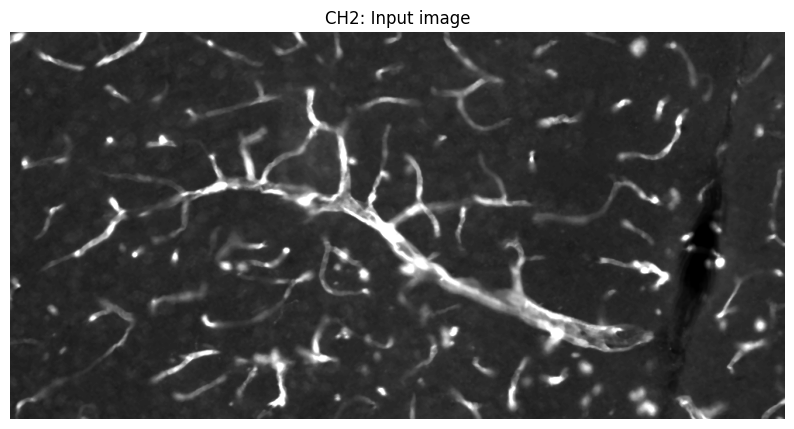

Input image type: float32
Input image min: 0.0
Input image max: 65025.0
Vesselness image statistics:
Shape: (500, 1000)
Min: 0.0
Max: 255.0
Mean: 211.17365
Median: 252.0
CHANNEL 2


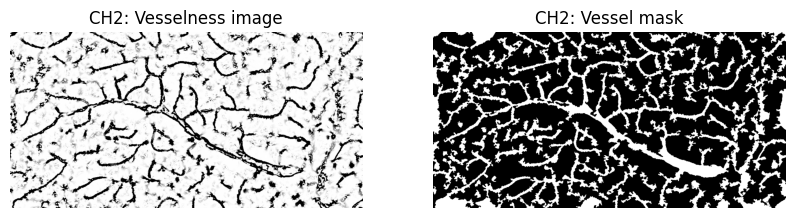

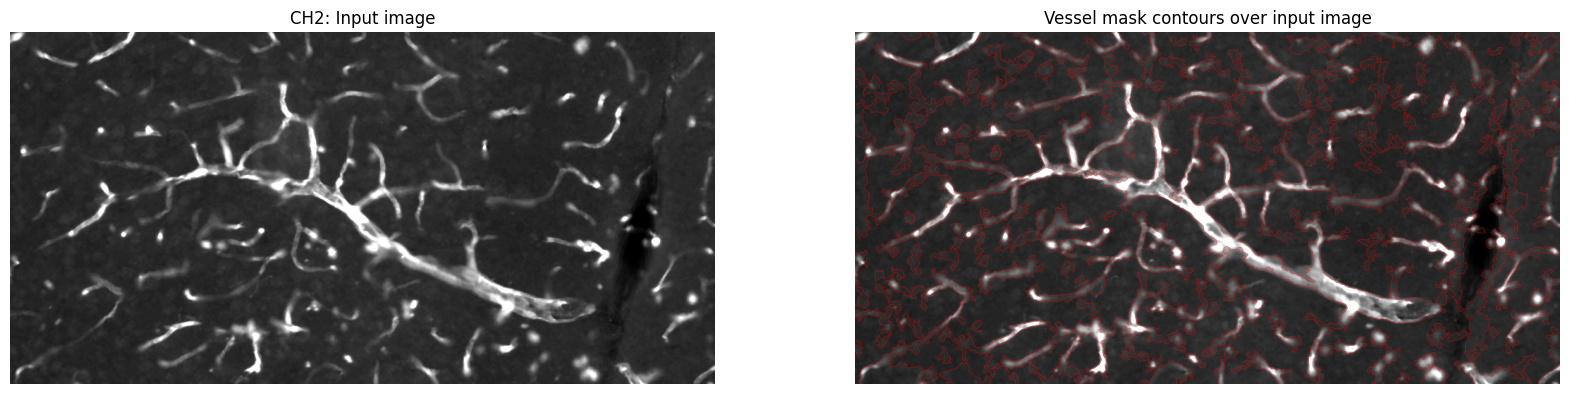

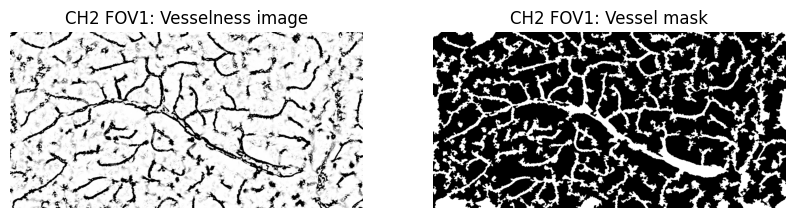

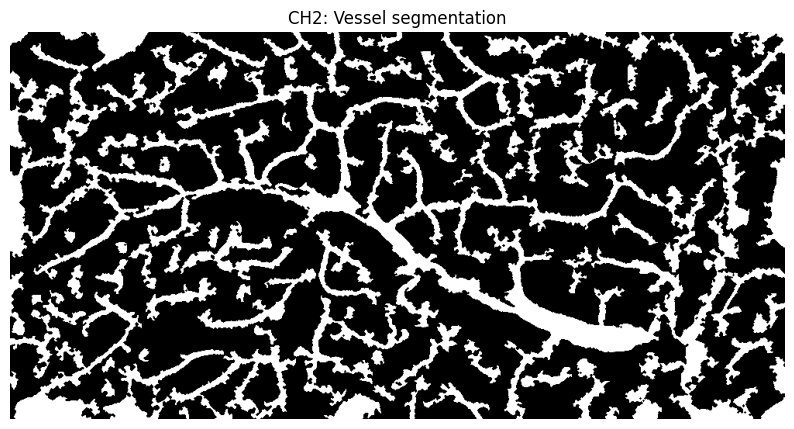

In [41]:
# Parameters for vessel detection
sigma_minimum = 1.0  # Range of scales in which MultiScaleHessianBasedMeasureImageFilter will search for vessels
sigma_maximum = 10.0  # 10
number_of_sigma_steps = 10  # 10 Number of scales to search for vessels

# Parameters for post-processing
thresh = 230  # Threshold for binarization, 230
min_size = 100  # Minimum size of objects to keep
area_threshold = 2000 # Minimum area of holes to keep
smoothing = 1  # Smoothing factor for closing, 3

#############################################################

# Alternative: load image in memory
input_image = curr_ch2_median * bg_mask
input_image = input_image.astype(np.float32)
input_image *= 255.0

show(input_image, title="CH2: Input image", axis=False)

# Print statistics
print("Input image type:", input_image.dtype)
print("Input image min:", input_image.min())
print("Input image max:", input_image.max())

# Run the vessel detection
segmented_vessels_array = detect_vessels(input_image, sigma_minimum, sigma_maximum, number_of_sigma_steps)

# Process the thresholded vessels
thresholded_vessels_ch2 = process_vessels(segmented_vessels_array, thresh=thresh, min_size=min_size, area_threshold=area_threshold, smoothing=smoothing)
thresholded_vessels_ch2 = thresholded_vessels_ch2 * bg_mask #* curr_ch2_thresh

# Print statistics
print("Vesselness image statistics:")
print("Shape:", segmented_vessels_array.shape)
print("Min:", segmented_vessels_array.min())
print("Max:", segmented_vessels_array.max())
print("Mean:", segmented_vessels_array.mean())
print("Median:", np.median(segmented_vessels_array))
#print("Std:", segmented_vessels_array.std())

print("CHANNEL 2")

# Plot the raw vesselness image
show(image=segmented_vessels_array, title=f"CH2: Vesselness image",
     image2=thresholded_vessels_ch2, title2=f"CH2: Vessel mask",
     axis=False)

# Show the results
show(image=input_image, title="CH2: Input image",
     image2=input_image, title2="Vessel mask contours over input image",
     contour2=thresholded_vessels_ch2, contour_alpha=0.45,
     figsize=(20, 10),
     axis=False)

# Plot the raw vesselness image FOV1
show(image=segmented_vessels_array, title=f"CH2 FOV1: Vesselness image",
     image2=thresholded_vessels_ch2, title2=f"CH2 FOV1: Vessel mask",
     axis=False)

# Full section
show(image=thresholded_vessels_ch2, title="CH2: Vessel segmentation",
     figsize=(10, 10), axis=False)

## Compute statistics 

i = 0:

idx = 0
beta = 0.5
thresh1 = 3200
thresh2 = 3000
Dice coefficient: 0.06844731078121227
IoU score: 0.035436419189215064
Precision score: 0.3455985254462903
Recall score: 0.03798522609181731
SSIM score: 0.6930462102036893
MSE score: 0.137799
Hamming distance: 0.137799
Rand index: 0.862201
Precision score 2: 0.03798522609181731
Recall score 2: 0.3455985254462903

i = 1:

idx = 1
beta = 0.5
thresh1 = 3200
thresh2 = 2800
Dice coefficient: 0.03839529029231591
IoU score: 0.01957340849678011
Precision score: 0.37444995459942465
Recall score: 0.020235075640909494
SSIM score: 0.7114446613769282
MSE score: 0.1342655
Hamming distance: 0.1342655
Rand index: 0.8657345
Precision score 2: 0.020235075640909494
Recall score 2: 0.37444995459942465

i = 2:

idx = 2
beta = 0.5
thresh1 = 3200
thresh2 = 3400
Dice coefficient: 0.1608898776418244
IoU score: 0.08748245996032343
Precision score: 0.3146119553868843
Recall score: 0.10808071894401536
SSIM score: 0.7969213438371732
MSE score: 0.0910224398782442
Hamming distance: 0.0910224398782442
Rand index: 0.9089775601217558
Precision score 2: 0.10808071894401536
Recall score 2: 0.3146119553868843



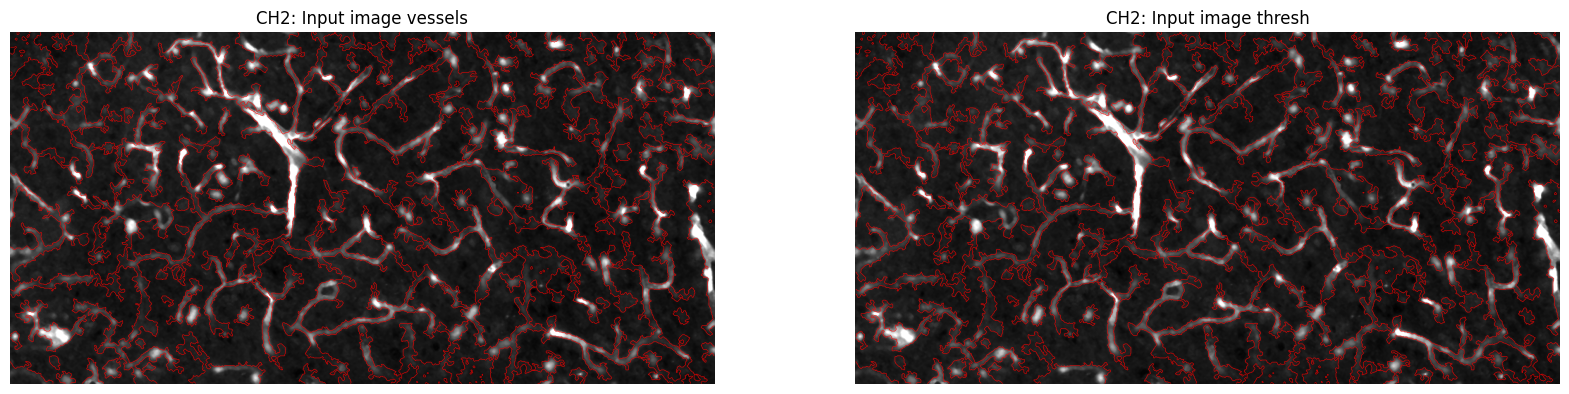

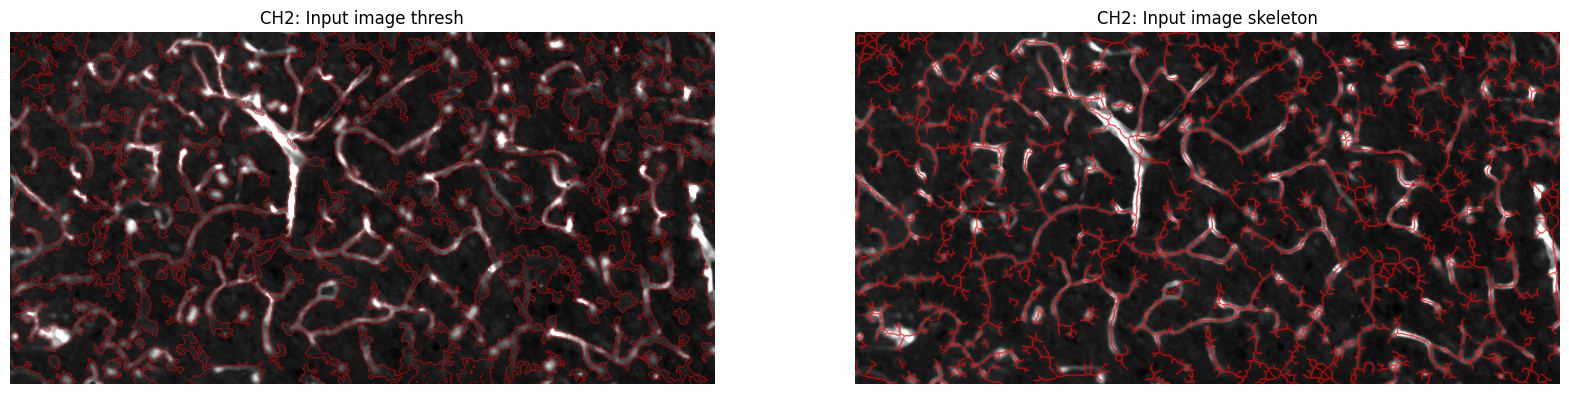

Lengths: [103.4816579099211, 573.7862242413954, 26.419655544787084, 51.61117343639287, 147.7442448878105, 81.77091694922997, 41.93296737053209, 59.23053477036378, 228.31916030591088, 24.888258640290182, 49.71023255314672, 305.0611784663885, 80.47895609449634, 33.42786049095494, 132.46841379023815, 57.773773580524264, 111.02147942437625, 51.912787031648904, 28.961357129813944, 21.39713683056034, 363.7759758670201, 160.8072385842494, 35.558183430496356, 22.950090925856134, 44.451207159707, 104.57862937716291, 467.1737640121888, 25.07148535231085, 28.229840628490223, 59.94474361620673, 29.792196044490776, 147.71669329847367, 50.70370361763232, 248.20220595783147, 54.231098805956165, 27.203750413031372, 403.0025474203732, 16.205027715916813, 205.3728010539247, 18.446169794238354, 14.977920246580846, 92.8097662827068, 87.92532890728275, 18.173715132331136, 17.730442925971346, 112.14094627733675, 29.77144501799192, 31.3309968992115, 26.180696218021687, 42.121372922539145, 27.07164627405872, 

Run the whole thing

## Threshold method (batch)

In [141]:
from tqdm import tqdm

data_path = "/media/data/u01/Fig2025/Supplemental Fig3 DE/M1/*.tif"
#output_ch1_path = "/media/data/u01/Fig2025/quant-fig2025/Supple-4a-M1/segmentation/ch1/"
output_ch2_path = "/media/data/u01/Fig2025/quant-fig2025/Supple-4a-M1/segmentation/ch2/"
output_ch3_path = "/media/data/u01/Fig2025/quant-fig2025/Supple-4a-M1/segmentation/ch3/"
output_csv_ch2_ch3_path = "/media/data/u01/Fig2025/quant-fig2025/Supple-4a-M1/stats_ch2_ch3.csv"

################################################################################

# Parameters for vessel detection
sigma_minimum = 1.0  # Range of scales in which MultiScaleHessianBasedMeasureImageFilter will search for vessels
sigma_maximum = 10.0  # 10
number_of_sigma_steps = 10  # 10 Number of scales to search for vessels

# Parameters for post-processing
thresh1 = 230  # Threshold for binarization, 230 (ch1)
thresh2 = 230  # Threshold for binarization, 230 (ch2)
thresh3 = 230
min_size1 = 100  # Minimum size of objects to keep (ch1)
min_size2 = 100  # Minimum size of objects to keep (ch2)
min_size3 = 20
area_threshold = 2000 # Minimum area of holes to keep
smoothing = 1  # Smoothing factor for closing, 3

# Read all tif files in the folder
data_files = sorted(glob.glob(data_path))
num_slices = len(data_files)
rows_ch2_ch3 = [["Index", "Dice coefficient", "IoU score", "Precision", "Recall", "SSIM", "MSE", "Hamming distance", "Rand index"]]

# Load the image channels
for i in tqdm(range(num_slices)):
    filepath = data_files[i]
    # Load the image channels
    curr_img = load_channel(filepath, IDX)
    #curr_ch1 = curr_img[:, :, 0]
    curr_ch2 = curr_img[:, :, 1]
    curr_ch3 = curr_img[:, :, 2]

    #curr_ch1 = curr_ch1.astype(np.float32)
    curr_ch2 = curr_ch2.astype(np.float32)
    curr_ch3 = curr_ch3.astype(np.float32)

    # Ch1 settings
    #gamma_ch1 = 2  # You can adjust this value to control the contrast enhancement
    #contrast_alpha_ch1 = 0.02 # 2

    # Ch2 settings
    #gamma_ch2 = 2  # You can adjust this value to control the contrast enhancement
    #contrast_alpha_ch2 = 0.02  # Try 0.15 You can adjust this value to control the brightness enhancement 0.5 default

    THRESH = 100
    THRESH2 = 50
    THRESH3 = 25

    """
    if i == 0:
        THRESH = 3200  # 6000
    elif i == 1:
        THRESH = 3200  # 6000
        THRESH2 = 2800
    elif i == 2:
        THRESH = 3200  # 6000
        THRESH2 = 3400
    """
            
    # Run N4 bias correction
    #bg_alpha = 99
    #bg_mask = auto_contrast(curr_ch1, alpha=bg_alpha)
    #bg_mask = get_brain_mask(bg_mask, area_threshold=25000)  # 255 default ch0, 150 for ch1
    bg_mask = np.ones(curr_ch1.shape, dtype=bool)
    
    
    #curr_ch1 = n4_bias_correction(curr_ch1, bg_mask, shrink_factor=2, show=False)
    curr_ch2 = n4_bias_correction(curr_ch2, bg_mask, shrink_factor=2, show=False)
    curr_ch3 = n4_bias_correction(curr_ch3, bg_mask, shrink_factor=2, show=False)
    
    # Create a threshold mask for the image
    #curr_ch1_median = ndimage.median_filter(curr_ch1.copy(), size=3)
    curr_ch2_median = ndimage.median_filter(curr_ch2.copy(), size=3)  # Repeat for ch2
    curr_ch3_median = ndimage.median_filter(curr_ch3.copy(), size=3)  # Repeat for ch3
    
    #cc_ch1_alt = gamma_correction(curr_ch1_median, gamma=gamma_ch1, max_value=max_value)

    #curr_ch1_thresh = curr_ch1_median.copy() > THRESH
    #curr_ch1_thresh[curr_ch1_thresh != 0] = 1
    #curr_ch1_thresh = curr_ch1_thresh.astype(bool)
    
    curr_ch2_thresh = curr_ch2_median.copy() > THRESH2
    curr_ch2_thresh[curr_ch2_thresh != 0] = 1
    curr_ch2_thresh = curr_ch2_thresh.astype(bool)
    
    curr_ch3_thresh = curr_ch3_median.copy() > THRESH3
    curr_ch3_thresh[curr_ch3_thresh != 0] = 1
    curr_ch3_thresh = curr_ch3_thresh.astype(bool)

    #auto_ch1 = auto_contrast(curr_ch1, alpha=contrast_alpha_ch1)
    #auto_ch2 = auto_contrast(curr_ch2, alpha=contrast_alpha_ch2)
    #auto_ch1_median = ndimage.median_filter(auto_ch1.copy(), size=5)
    #auto_ch2_median = ndimage.median_filter(auto_ch2.copy(), size=5)


    #input_ch1 = curr_ch1_median * bg_mask
    #input_ch1 = input_ch1.astype(np.float32)
    #input_ch1 *= 255.0
        
    input_ch2 = curr_ch2_median * bg_mask
    input_ch2 = input_ch2.astype(np.float32)
    input_ch2 *= 255.0
    
    input_ch3 = curr_ch3_median * bg_mask
    input_ch3 = input_ch3.astype(np.float32)
    input_ch3 *= 255.0


    # Run the vessel detection
    #segmented_vessels_ch1 = detect_vessels(input_ch1, sigma_minimum, sigma_maximum, number_of_sigma_steps)
    segmented_vessels_ch2 = detect_vessels(input_ch2, sigma_minimum, sigma_maximum, number_of_sigma_steps)
    segmented_vessels_ch3 = detect_vessels(input_ch3, sigma_minimum, sigma_maximum, number_of_sigma_steps)

    # Process the thresholded vessels
    #thresholded_vessels_ch1 = process_vessels(segmented_vessels_ch1, thresh=thresh1, min_size=min_size1, area_threshold=area_threshold, smoothing=smoothing)
    thresholded_vessels_ch2 = process_vessels(segmented_vessels_ch2, thresh=thresh2, min_size=min_size2, area_threshold=area_threshold, smoothing=smoothing)
    thresholded_vessels_ch3 = process_vessels(segmented_vessels_ch3, thresh=thresh3, min_size=min_size3, area_threshold=area_threshold, smoothing=smoothing)

    #thresholded_vessels_ch1 = thresholded_vessels_ch1 * bg_mask * curr_ch1_thresh
    thresholded_vessels_ch2 = thresholded_vessels_ch2 * bg_mask * curr_ch2_thresh
    thresholded_vessels_ch3 = thresholded_vessels_ch3 * bg_mask * curr_ch3_thresh
    
    show(input_ch2, title="CH2: Image", axis=False,
         contour=thresholded_vessels_ch2,
         image2=input_ch3, title2="CH3: Image",
         contour2=thresholded_vessels_ch3)
    
    # Save to file
    #sitk_ch1 = sitk.GetImageFromArray(thresholded_vessels_ch1.astype(np.uint8))  # Ch1
    #output_ch1_file = output_ch1_path + f"ch3_seg_{str(i).zfill(4)}.tif"
    #sitk.WriteImage(sitk_ch1, output_ch1_file)
    sitk_ch2 = sitk.GetImageFromArray(thresholded_vessels_ch2.astype(np.uint8))  # Ch2
    output_ch2_file = output_ch2_path + f"ch2_seg_{str(i).zfill(4)}.tif"
    sitk.WriteImage(sitk_ch2, output_ch2_file)
    sitk_ch3 = sitk.GetImageFromArray(thresholded_vessels_ch3.astype(np.uint8))  # Ch3
    output_ch3_file = output_ch3_path + f"ch3_seg_{str(i).zfill(4)}.tif"
    sitk.WriteImage(sitk_ch3, output_ch2_file)
    
    # Compute statistics between ch1 and ch2
    #thresh_ch1_flat = thresholded_vessels_ch1.flatten()
    thresh_ch2_flat = thresholded_vessels_ch2.flatten()
    thresh_ch3_flat = thresholded_vessels_ch3.flatten()
    dice_score = dice_coefficient(thresholded_vessels_ch2, thresholded_vessels_ch3)  
    iou_score = iou(thresholded_vessels_ch2, thresholded_vessels_ch3)  # Strongly penalizes over-segmentation and under-segmentation
    precision_score = precision(thresholded_vessels_ch2, thresholded_vessels_ch3) 
    recall_score = recall(thresholded_vessels_ch2, thresholded_vessels_ch3)
    ssim_score = ssim(thresholded_vessels_ch2, thresholded_vessels_ch3)
    mse_score = mean_squared_error(thresholded_vessels_ch2, thresholded_vessels_ch3)
    hamming_distance = hamming(thresh_ch2_flat, thresh_ch3_flat)
    rand_score = rand_index(thresholded_vessels_ch2, thresholded_vessels_ch3)  # Measures how close points are clustered together
    rows_ch2_ch3.append([i, dice_score, iou_score, precision_score, recall_score, ssim_score, mse_score, hamming_distance, rand_score])
    print("ch2-ch3:", rows_ch2_ch3[i + 1])

with open(output_csv_ch2_ch3_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows_ch2_ch3)

  0%|          | 0/3 [00:00<?, ?it/s]

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


Found 3 slices
['/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 1/CH1-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 1/CH3-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 3/CH1-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 3/CH3-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 4/CH1-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 4/CH3-1.tif']

Ch1: /media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 1/CH1-1.tif
Ch2: /media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 1/CH3-1.tif

Channel shape: (1000, 2000)
Channel dtype: uint16
Channel 1 min: 138
Channel 1 max: 65515
Channel 1 mean: 2865.6253095


 33%|███▎      | 1/3 [00:03<00:07,  3.84s/it]

ch1-ch2: [0, 0.06844731078121227, 0.035436419189215064, 0.3455985254462903, 0.03798522609181731, 0.6930462102036893, 0.137799, 0.137799, 0.862201]
Found 3 slices
['/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 1/CH1-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 1/CH3-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 3/CH1-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 3/CH3-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 4/CH1-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 4/CH3-1.tif']

Ch1: /media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 3/CH1-1.tif
Ch2: /media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 3/CH3-1.tif

Channel shape: (1000, 2000)
Channel dtype: uint16
Channel 1 min: 87
Channel 1 max: 64411
Channel 1 mean: 2616.5929125


TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
 67%|██████▋   | 2/3 [00:07<00:03,  3.82s/it]

ch1-ch2: [1, 0.03839529029231591, 0.01957340849678011, 0.37444995459942465, 0.020235075640909494, 0.7114446613769282, 0.1342655, 0.1342655, 0.8657345]
Found 3 slices
['/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 1/CH1-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 1/CH3-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 3/CH1-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 3/CH3-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 4/CH1-1.tif',
 '/media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 4/CH3-1.tif']

Ch1: /media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 4/CH1-1.tif
Ch2: /media/data/u01/Fig2025/Supple-4a-M1/Supple Fig4a_M1_slice 4/CH3-1.tif

Channel shape: (1967, 2212)
Channel dtype: uint16
Channel 1 min: 10
Channel 1 max: 59999
Channel 1 mean: 2187.24133211553


TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
100%|██████████| 3/3 [00:15<00:00,  5.24s/it]

ch1-ch2: [2, 0.1608898776418244, 0.08748245996032343, 0.3146119553868843, 0.10808071894401536, 0.7969213438371732, 0.0910224398782442, 0.0910224398782442, 0.9089775601217558]


In [117]:
"""
i=0 should match:

"""

'\ni=0 should match:\n\n'